Source
-- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
import math
import numpy as np
import matplotlib.pyplot as plt
# from cnnDataset import CNNDataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
resizer = 1
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize([64*resizer, 64*resizer]), # This line
                               torchvision.transforms.Normalize((.5,.5,.5), (.5,.5,.5))
                                ])
# load dataset 
# csv_path = 'C:\\Users\\amart50\\Desktop\\CNN_test\\cnn_name_class.csv'
# data_path = 'C:\\Users\\amart50\\Desktop\\CNN_test\\Data_Cnn'

# dataset = CNNDataset(csv_file='cnn_name_class.csv', root_dir='Data_cnn', transform=transform)

In [9]:
data_path = 'C:\\Users\\amart50\\Desktop\\ViTPose\\298_scripts\\CNN_test\\data'
dataset = ImageFolder(data_path, transform=transform)

In [10]:
batch_size = 1
train_split = int( len(dataset) * .8)
test_split = len(dataset)- train_split
print(train_split, test_split, train_split+test_split, len(dataset))

840 210 1050 1050


In [11]:

train_set, test_set = torch.utils.data.random_split(dataset, [train_split, test_split])
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [12]:
# dataset.__getitem__(0)
dataset.classes, trainloader, testloader

(['Bench', 'Deadlift', 'Squat'],
 <torch.utils.data.dataloader.DataLoader at 0x1f94ed45690>)

In [13]:
img, label = next(iter(trainloader))
print(f"Image Shape:{img.shape} (B, corlorchannel, H, W)")
print(f"Image Shape:{label.shape} (B, corlorchannel, H, W)")

Image Shape:torch.Size([1, 3, 64, 64]) (B, corlorchannel, H, W)
Image Shape:torch.Size([1]) (B, corlorchannel, H, W)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


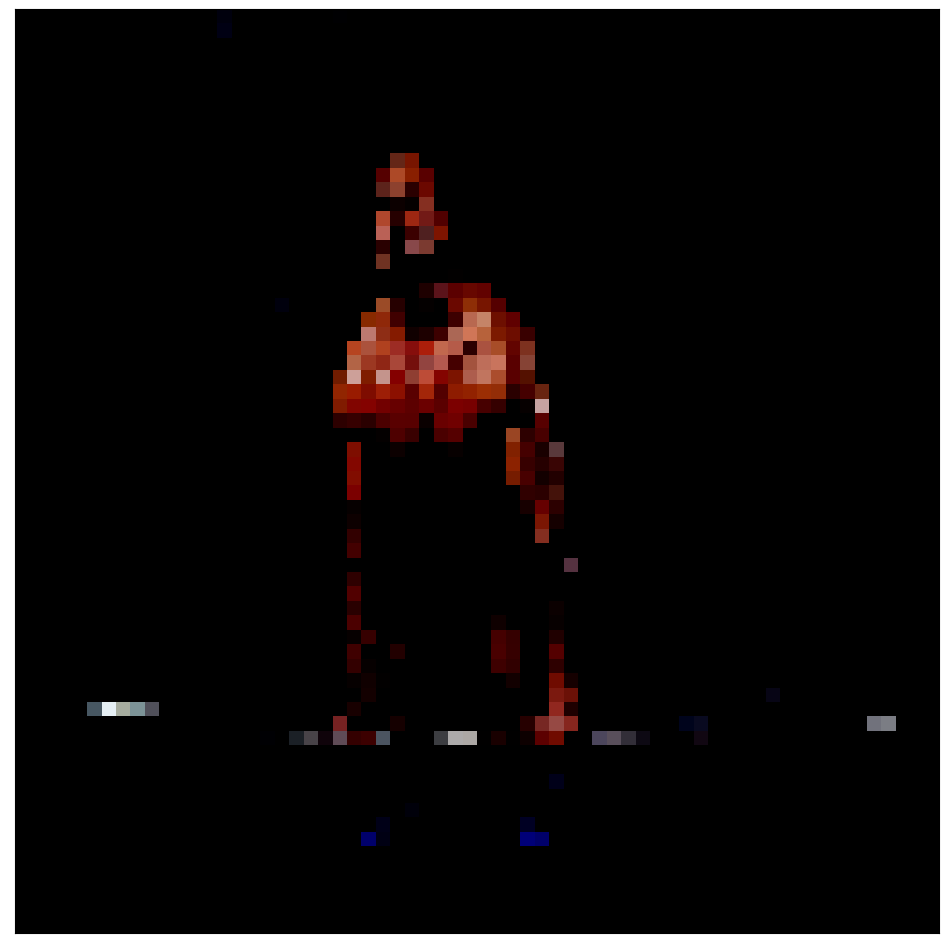

In [14]:
# grid_img = torchvision.utils.make_grid(images[:4])
# import matplotlib.pyplot as plt
# plt.imshow(grid_img.permute(1, 2, 0))
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(trainloader)

In [15]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=2* hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=2* hidden_units,
                  out_channels=4* hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=4* hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))
        
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [16]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=16,
                  output_shape=len(dataset.classes)).to(device)
model_0
     

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=3, bias=True)
  )
)

In [17]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[-0.0395, -0.0189, -0.0654]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) 

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc 
     

In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc
     

In [20]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results
     

In [21]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(dataset.classes)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)


In [23]:
model_0_results = train(model=model_0,
                        train_dataloader=trainloader,
                        test_dataloader=testloader,
                        optimizer=optimizer,
                        epochs=1)

100%|██████████| 1/1 [00:21<00:00, 21.09s/it]

Epoch: 1 | train_loss: 1.0853 | train_acc: 0.4250 | test_loss: 1.0897 | test_acc: 0.4000


In [26]:
import sys 
sys.path.append('C:\\Users\\amart50\\Desktop\\liftingpose')
from CNN import ResNet, block

model_1 = ResNet(in_channels=128, block=block, layers=[3,4,6,3], image_channels=3, num_classes=3)

#train model 1
train(model=model_1,
        train_dataloader=trainloader,
        test_dataloader=testloader,
        optimizer=optimizer,
        epochs=5)

AttributeError: 'ResNet' object has no attribute 'to_device'

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# for epoch in range(num_epochs):
#     losses = []
#     for batch_idx, (data, targets) in enumerate(trainloader):
#         # Get data to cuda if possible
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)
#         losses.append(loss.item())
        
#         # backward
#         optimizer.zero_grad()
#         loss.backward()
        
#         # gradient descent or adam step
#         optimizer.step()
        
#     print(f'Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}')

In [ ]:
# class Net(nn.Module):
#     """
#     CNN model for lift classification with 3 output layers classifying 
#     the lift as Squat, Bench, or Deadlift
#     """

#     def __init__(self):
#         super().__init__()
#         #define a 3 layer CNN
#         self.conv1 = nn.Conv2d(3,1 , 256) # 1 input channel, 32 output channels, 3x3 kernel, stride 1, padding 1
#         self.conv2 = nn.Conv2d(256, 256*2, 5) # 32 input channels, 64 output channels, 3x3 kernel, stride 1, padding 1
#         self.maxpool_layer = nn.MaxPool2d(3, 3) # 2x2 kernel, stride 2
#         self.fc_layer = nn.Linear(256*5*5, 3) # 64*5*5 input features, 3 output features (for 3 classes)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.maxpool_layer(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.maxpool_layer(x)
#         x = x.view(-1, 256*5*5) 
#         x = torch.sigmoid(self.fc_layer(x))
#         return x
    

#     # def test_one(self, image, label):
#     #     outputs = self(image)
#     #     _, predicted = torch.max(outputs.data, 1)
#     #     print('Predicted: ', predicted.item(), 'Actual: ', label.item())


In [ ]:
# import cv2
# x = iter(trainloader)
# images, labels = next(x)
trainloader.Classes

AttributeError: 'DataLoader' object has no attribute 'Classes'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


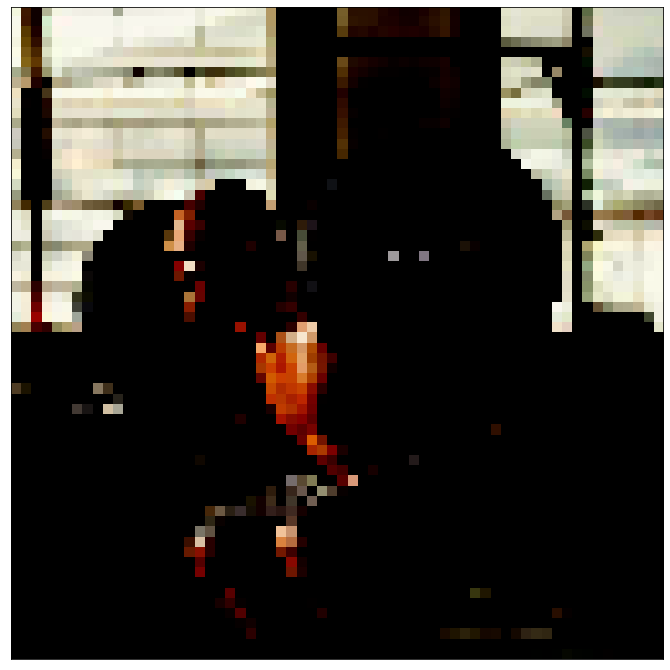

In [ ]:
# grid_img = torchvision.utils.make_grid(images[:4])
# import matplotlib.pyplot as plt
# plt.imshow(grid_img.permute(1, 2, 0))
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(trainloader)

In [ ]:
import torch

# Define the dimensions of the input image
width = 256
height = 256

# Define the number of classes in the dataset
num_classes = 3

# Define the neural network architecture
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.fc1 = torch.nn.Linear(64 * width * height, 512)
    self.fc2 = torch.nn.Linear(512, num_classes)
  
  def forward(self, x):
    x = torch.nn.functional.relu(self.conv1(x))
    x = torch.nn.functional.relu(self.conv2(x))
    x = torch.nn.functional.relu(self.conv3(x))
    x = x.view(-1, 64 * width * height)
    x = torch.nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Create an instance of the neural network
model = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, data, optimizer):
  # Set the model to training mode
  model.train()

  # Initialize the average loss
  avg_loss = 0.0

  # Loop over the training data
  for images, labels in data:
    # Clear the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)

    # Compute the loss
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    # Backward pass
    loss.backward()

    # Optimize the model's parameters
    optimizer.step()

    # Update the average loss
    avg_loss += loss.item()

  # Return the average loss
  return avg_loss / len(data)


def evaluate(model, data):
  # Set the model to evaluation mode
  model.eval()

  # Initialize the average accuracy
  avg_accuracy = 0.0

  # Loop over the validation data
  for images, labels in data:
    # Forward pass
    outputs = model(images)

    # Compute the accuracy
    _, predictions = torch.max(outputs, dim=1)
    accuracy = torch.mean(predictions.eq(labels).float())

    # Update the average accuracy
    avg_accuracy += accuracy.item()

  # Return the average accuracy
  return avg_accuracy / len(data)

In [ ]:
import matplotlib.pyplot as plt

# Train the model and record its accuracy on the training set and validation set
# at each epoch
train_accuracies = []
valid_accuracies = []
for epoch in range(num_epochs):
  # Train the model for one epoch
  train_accuracy = train(model, trainloader, optimizer)
  train_accuracies.append(train_accuracy)
  
  # Evaluate the model on the validation set
  valid_accuracy = evaluate(model, testloader)
  valid_accuracies.append(valid_accuracy)

# Create a plot of the model's accuracy versus the number of epochs
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train")
plt.plot(range(1, num_epochs + 1), valid_accuracies, label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

KeyboardInterrupt: 

In [ ]:
# # define the initial learning rate here
# learning_rate = 1e-2
# n_epochs = 30 # how many epochs to run

# # define loss function
# criterion = nn.BCELoss()
# cnn_net = Net()
# optimizer = torch.optim.SGD(cnn_net.parameters(), lr=learning_rate)

# for epoch in range(n_epochs):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 1):

#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         labels = labels.float()

#         # Forward 
#         output = cnn_net(inputs)
        
#         # Compute the loss using the final output
#         loss = criterion(output, labels)

#         # Backpropagation
#         # YOUR CODE HERE
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         #raise NotImplementedError()
        
#         # print statistics
#         running_loss += loss.item()
#         if i % 200 == 199:  # print every 200 mini-batches
#             print('[Epoch %d, Step %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 200))
#             running_loss = 0.0

# print('Finished Training')aaa

# CnNDataset debugging

In [ ]:
import pandas as pd 
import os
annotations = pd.read_csv('cnn_name_class.csv')
root_dir = 'C:\\Users\\amart50\\Desktop\\CNN_test\\Data_Cnn'
index = 0

In [ ]:
root_dir, annotations.iloc[index, 1]

('C:\\Users\\amart50\\Desktop\\CNN_test\\Data_Cnn', 'bench1.jpg')

In [ ]:
img_path = os.path.join(root_dir, annotations.iloc[index, 1])
img_path

'C:\\Users\\amart50\\Desktop\\CNN_test\\Data_Cnn\\bench1.jpg'

In [ ]:
name = annotations['Names']
new_name = []
for names in name:
    names = names.split("/")[1]
    new_name.append(names)

In [ ]:
annotations['Names'].replace(new_name)
annotations.head()

,Names,Class
0,bench/bench0.jpg,0
1,bench/bench1.jpg,0
2,bench/bench10.jpg,0
3,bench/bench100.jpg,0
4,bench/bench101.jpg,0


In [ ]:
len(annotations), len(new_name)

(1043, 1043)

In [ ]:
annotations.head()

,Names,Class
0,bench/bench0.jpg,0
1,bench/bench1.jpg,0
2,bench/bench10.jpg,0
3,bench/bench100.jpg,0
4,bench/bench101.jpg,0


In [ ]:
annotations["Names"] = new_name

In [ ]:
annotations.to_csv("cnn_name_class.csv")